In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
train_df = pd.read_table("2013_Queensland_Floods_train.tsv")
test_df = pd.read_table("2013_Queensland_Floods_test.tsv")
col_names = train_df.columns
train_df["text"]

0       I just though about the night I went clubbing ...
1       Looks like its going to be another long night ...
2       @LaniiBanani hahahaha I just told him id have ...
3       Off to meeting.... with so called... Baaps of ...
4                Doubt I'll be getting much sleep tonight
                              ...                        
6014    RT @GrillTeam: The Queensland government has s...
6015    Can we have 5 NEMA staff from Nigeria  come to...
6016    RT @7NewsBrisbane: Foam from rough waves at Al...
6017    RT @abcsouthqld: Master Electricians Australia...
6018    RT @HomeLoanKing: Leader of Aussie opposition,...
Name: text, Length: 6019, dtype: object

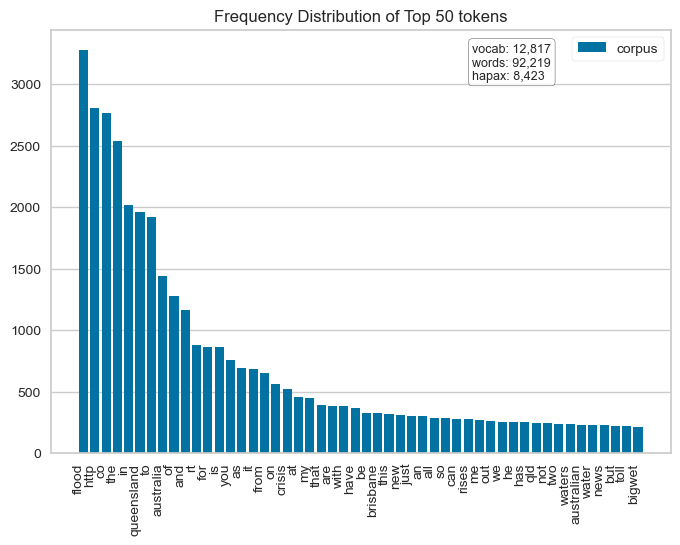

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(train_df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
train_text = train_df["text"]
train_labels = train_df["label"]

test_text = test_df["text"]
test_labels = test_df["label"]

print(train_text.shape)
print(test_text.shape)

(6019,)
(3011,)


In [5]:
# remove digits, @-mentions, links, stopwords

train_text = train_text.str.lower()
#train_text = train_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
train_text = train_text.apply(lambda x : nltk.word_tokenize(x))
train_text = train_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

test_text = test_text.str.lower()
#test_text = test_text.apply(lambda elem: re.sub(r"\d+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
test_text = test_text.apply(lambda x : nltk.word_tokenize(x))
test_text = test_text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

train_text.shape

(6019,)

In [6]:
# include the hashtag anyway because #savehaiti is different from savehaiti
train_text = train_text.apply(lambda elem: re.sub(r"#", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\.", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\,", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\?", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\!", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\:", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\;", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\-", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\'", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\_", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\/", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\*", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\%", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\&", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\\", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"@", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\$", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\[", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\]", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\~", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\(", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\)", "", elem))
train_text = train_text.apply(lambda elem: re.sub("http", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
train_text = train_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
train_text = train_text.apply(lambda elem: re.sub(r"\s+$", "", elem))

test_text = test_text.apply(lambda elem: re.sub(r"#", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\.", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\,", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\?", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\!", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\:", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\;", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\-", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\'", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\_", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\/", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\*", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\%", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\&", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\\", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@\s[a-zA-Z0-9]+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"@", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\$", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\[", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\]", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\~", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\(", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\)", "", elem))
test_text = test_text.apply(lambda elem: re.sub("http", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s\s*", " ", elem))
test_text = test_text.apply(lambda elem: re.sub(r"^\s+", "", elem))
test_text = test_text.apply(lambda elem: re.sub(r"\s+$", "", elem))


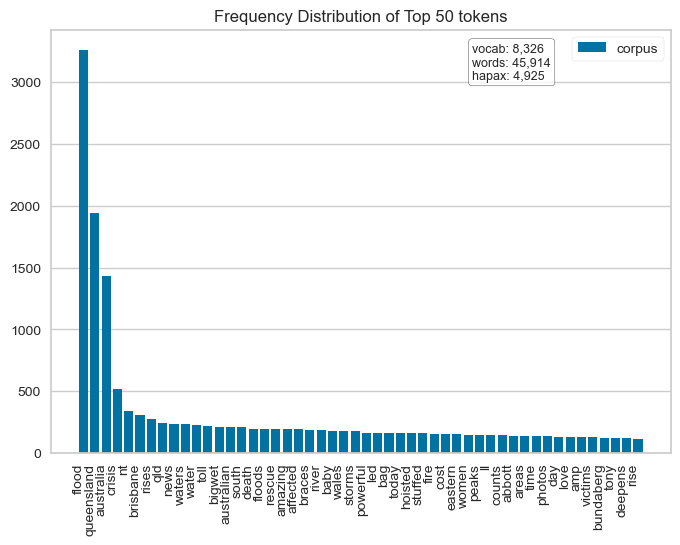

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [7]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(pd.DataFrame(train_text)["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

b'not_relevant' 	 0.46037547765409537
b'relevant' 	 0.5396245223459046


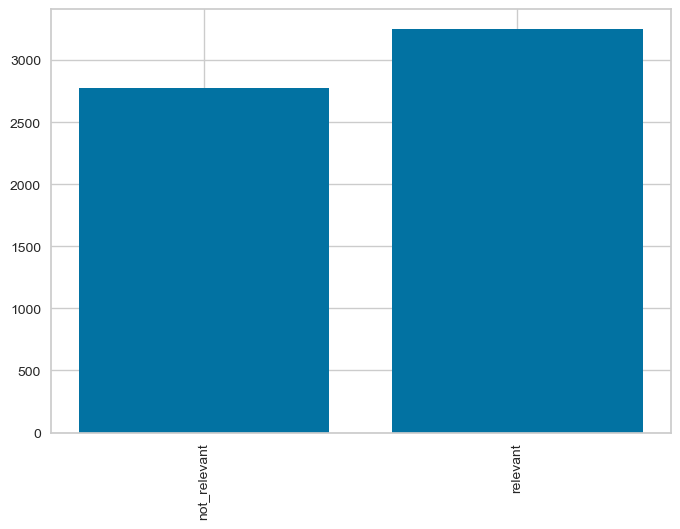

In [8]:
train_text = tf.convert_to_tensor(train_text)
train_labels = tf.convert_to_tensor(train_labels)

test_text = tf.convert_to_tensor(test_text)
test_labels = tf.convert_to_tensor(test_labels)

labels = tf.unique(train_labels)[0]
#print(np.array(tf.unique(train_labels)[1]))

for x in range(0,len(labels)):
  print(np.array(labels)[x], '\t', np.mean(x == tf.unique(train_labels)[1]))
plt.bar(np.array(labels), [np.sum(x == tf.unique(train_labels)[1]) for x in range(0,len(labels))])
plt.xticks(rotation = 90)
plt.show()

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
X_train, _, y_train, _ = train_test_split(np.array(train_text), np.array(train_labels), train_size=500, shuffle=True)
for i in range(len(X_train)):
  X_train[i] = str(X_train[i])[2:-1]
  X_train[i] = tokenizer.tokenize(X_train[i])
  X_train[i] = tokenizer.convert_tokens_to_ids(X_train[i])

X_test, _, y_test, _ = train_test_split(np.array(test_text), np.array(test_labels), train_size=100, shuffle=True)
for i in range(len(X_test)):
  X_test[i] = str(X_test[i])[2:-1]
  X_test[i] = tokenizer.tokenize(X_test[i])
  X_test[i] = tokenizer.convert_tokens_to_ids(X_test[i])

In [11]:
import torch

max_length = 64
model.config.max_position_embeddings = max_length

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [12]:
print(X_train_padded)

tensor([[ 4035,  2739,  2350,  ...,     0,     0,     0],
        [ 7186, 13531,  6959,  ...,     0,     0,     0],
        [ 2660,  3539,  2704,  ...,     0,     0,     0],
        ...,
        [13864,  2209,  2067,  ...,     0,     0,     0],
        [ 7186,  5380,  2132,  ...,     0,     0,     0],
        [27785,  5786,  4203,  ...,     0,     0,     0]], dtype=torch.int32)


In [13]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0485,  0.2270,  0.2899,  ..., -0.4116,  0.7035,  0.1859],
         [-0.0099, -0.0326,  0.3232,  ..., -0.3453,  0.3089, -0.2219],
         [-0.3342, -0.1382,  0.2551,  ..., -0.4796, -0.0187, -0.2799],
         ...,
         [ 0.2096,  0.2155,  0.5575,  ..., -0.6417,  0.9432,  0.1333],
         [ 0.1967,  0.2390,  0.5986,  ..., -0.6055,  0.9702,  0.1368],
         [ 0.2000,  0.2732,  0.5880,  ..., -0.5650,  0.9621,  0.1281]],

        [[-0.1587,  0.0013,  0.0093,  ..., -0.8545,  0.8036,  0.0378],
         [-0.3210,  0.4697,  0.1199,  ..., -0.9343,  0.4342,  0.0261],
         [-0.3382,  0.3818,  0.0277,  ..., -0.8465,  0.3958, -0.0361],
         ...,
         [-0.2709, -0.3762,  0.0326,  ..., -1.0457,  0.9741,  0.0729],
         [-0.2759, -0.3839,  0.0399,  ..., -1.0292,  0.9929,  0.0926],
         [-0.2823, -0.3435,  0.0257,  ..., -1.0203,  0.9890,  0.0984]],

        [[ 0.0822,  0.6837,  0.2067,  ..., -0.1571,  

In [14]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 1.0806e-01,  1.4562e-01,  4.6986e-03,  ..., -8.5787e-01,
           6.8477e-01,  1.7508e-01],
         [-9.3938e-02,  1.9386e-01,  4.5739e-01,  ..., -1.1593e+00,
           3.7286e-01,  5.3448e-01],
         [-2.9164e-01,  1.7638e-02,  6.3784e-02,  ..., -1.0403e+00,
           1.5528e-01,  4.3036e-01],
         ...,
         [ 4.1085e-02,  3.9985e-02, -3.3985e-02,  ..., -8.8756e-01,
           7.8617e-01,  9.8828e-02],
         [ 3.7595e-02,  3.7074e-02, -3.8014e-02,  ..., -8.7183e-01,
           8.1056e-01,  1.1784e-01],
         [ 4.2193e-02,  5.5495e-02, -4.8533e-02,  ..., -8.5601e-01,
           8.0556e-01,  1.0825e-01]],

        [[-2.8631e-01, -3.9984e-02,  2.6016e-02,  ..., -5.0685e-01,
           7.7711e-01,  4.3900e-02],
         [-4.7296e-01, -2.1996e-02,  4.1632e-01,  ..., -6.2949e-01,
           2.8541e-01,  3.3522e-01],
         [-2.7171e-01, -8.9765e-02,  3.9951e-01,  ..., -7.1840e-01,
           3.

In [15]:
print(bert_train_output[0].shape, bert_train_output[1].shape)
print(bert_test_output[0].shape, bert_test_output[1].shape)
print(type(bert_train_output[0]))

torch.Size([500, 64, 768]) torch.Size([500, 768])
torch.Size([100, 64, 768]) torch.Size([100, 768])
<class 'torch.Tensor'>


In [16]:
train_sequence_output = bert_train_output[1].detach().numpy().copy()
X_train = train_sequence_output.reshape(X_train.shape[0], 768)

test_sequence_output = bert_test_output[1].detach().numpy().copy()
X_test = test_sequence_output.reshape(X_test.shape[0], 768)

bert_train_output = None
bert_test_output = None

In [17]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [18]:
clf = neural_network.MLPClassifier()
clf.fit(X_train, le.transform(y_train))

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier()

In [19]:
clf2 = neural_network.MLPClassifier()
clf2.fit(X_train_padded, le.transform(y_train))

MLPClassifier()

In [20]:
print("Train accuracy:", np.mean(clf.predict(X_train) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(X_test) == le.transform(y_test)))

Train accuracy: 0.946
Test accuracy: 0.87


## SHAP

In [21]:
shap.initjs()

In [22]:
X_test_padded = np.array(X_test_padded)[:20]

In [23]:
def prediction_model(X):
  print(type(X), X)
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [24]:
X_test_padded.shape

(20, 64)

In [25]:
permutation_explainer = shap.explainers.Permutation(prediction_model, X_test_padded)
#permutation_explainer = shap.explainers.Permutation(clf2.predict, X_test_padded)

In [26]:
permutation_values = permutation_explainer(X_test_padded)

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  15%|█▌        | 3/20 [1:05:53<4:42:52, 998.38s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  20%|██        | 4/20 [1:55:50<8:08:20, 1831.29s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  25%|██▌       | 5/20 [2:32:06<8:09:59, 1959.94s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 5322.  9294.  7186. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  30%|███       | 6/20 [3:11:03<8:07:53, 2090.99s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  35%|███▌      | 7/20 [4:18:45<9:54:46, 2745.11s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  40%|████      | 8/20 [5:01:20<8:56:47, 2684.00s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  45%|████▌     | 9/20 [6:03:48<9:13:30, 3019.12s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  50%|█████     | 10/20 [6:34:08<7:21:08, 2646.89s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  55%|█████▌    | 11/20 [7:11:43<6:18:59, 2526.62s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 5322.  9294.  7186. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  60%|██████    | 12/20 [7:41:44<5:07:23, 2305.41s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  65%|██████▌   | 13/20 [8:16:11<4:20:32, 2233.17s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  70%|███████   | 14/20 [9:05:32<4:05:18, 2453.10s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  75%|███████▌  | 15/20 [9:34:25<3:06:19, 2235.90s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  80%|████████  | 16/20 [10:24:26<2:44:25, 2466.36s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  85%|████████▌ | 17/20 [11:37:22<2:32:02, 3040.72s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 4748.  2546.  8456. ...     0.     0.     0.]
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  90%|█████████ | 18/20 [12:08:46<1:29:46, 2693.24s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [23961.  5293. 24260. ...     0.     0.     0.]
 [ 1053.  4588. 16171. ...     0.     0.     0.]
 [ 1032.  1060.  2278. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer:  95%|█████████▌| 19/20 [12:45:18<42:22, 2542.44s/it]  

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [ 9252.  7186.  5380. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer: 100%|██████████| 20/20 [13:27:00<00:00, 2530.37s/it]

<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2095.  2222.  4469. ...     0.     0.     0.]
 [ 2843.  6082.  2128. ...     0.     0.     0.]
 [ 4301. 12583.  7186. ...     0.     0.     0.]
 ...
 [ 2128. 26560.  7741. ...     0.     0.     0.]
 [ 6300.  2050.  1055. ...     0.     0.     0.]
 [10201. 24367.  2482. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 2

Permutation explainer: 21it [13:57:50, 2513.54s/it]                        


In [27]:
print(permutation_values)

.values =
array([[-2.47222222e-01, -2.77777778e-03,  8.33333333e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.38888889e-01,  8.33333333e-03, -6.94444444e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.61111111e-02, -1.38888889e-02,  6.66666667e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.55555556e-02, -8.33333333e-03, -1.00000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.77777778e-01, -3.08395285e-18, -7.77777778e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.75000000e-01,  8.61111111e-02,  3.88888889e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])

.data =
array([[ 2095,  2222,  4469, ...,     0,     0,     0],
       [ 2843,  6082,  2128, ...,    

<class 'numpy.ndarray'> [[ 2095  2222  4469  7144 14110  8842  2185     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: year ll extra drunk emerald isle away ; Prediction: [0] ; True value: b'not_relevant'


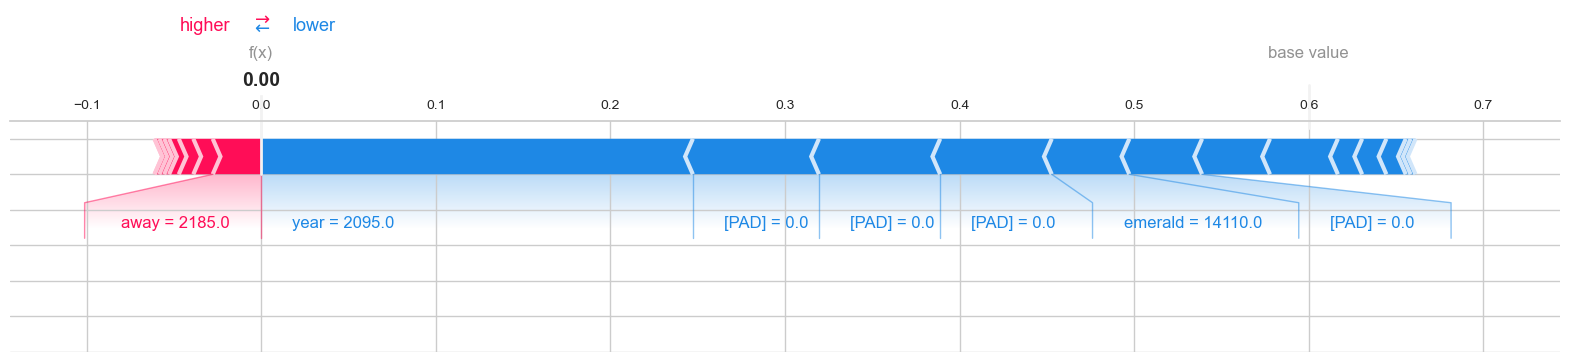

<class 'numpy.ndarray'> [[2843 6082 2128 2633 2188    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: lot easier re finally home ; Prediction: [0] ; True value: b'not_relevant'


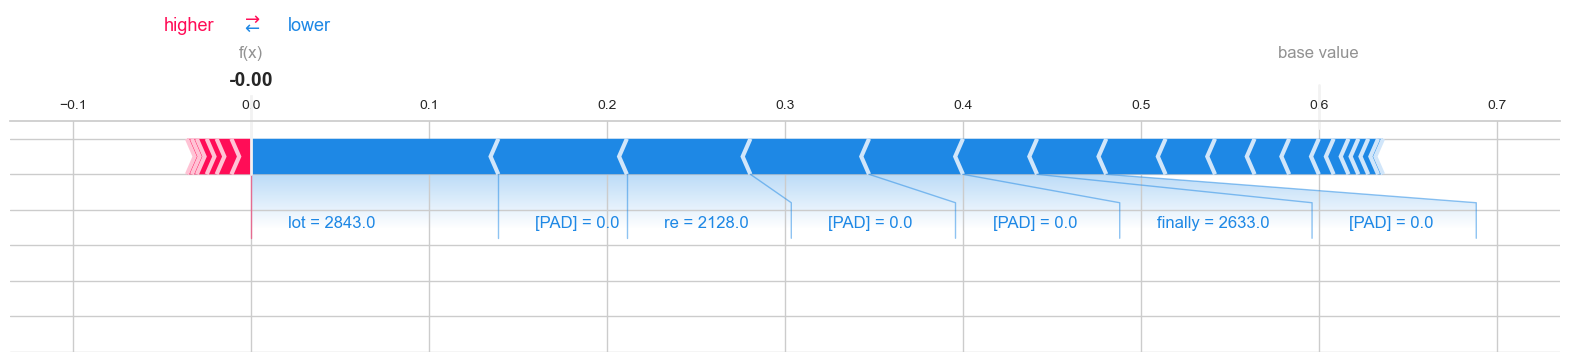

<class 'numpy.ndarray'> [[ 4301 12583  7186  3466  2098  5322  2642 11524  2502  8545  2102  1053
   6392 10258 17139  2015     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: thoughts prayers flood effect ##ed queensland northern nsw big ##we ##t q ##ld ##fl ##ood ##s ; Prediction: [1] ; True value: b'relevant'


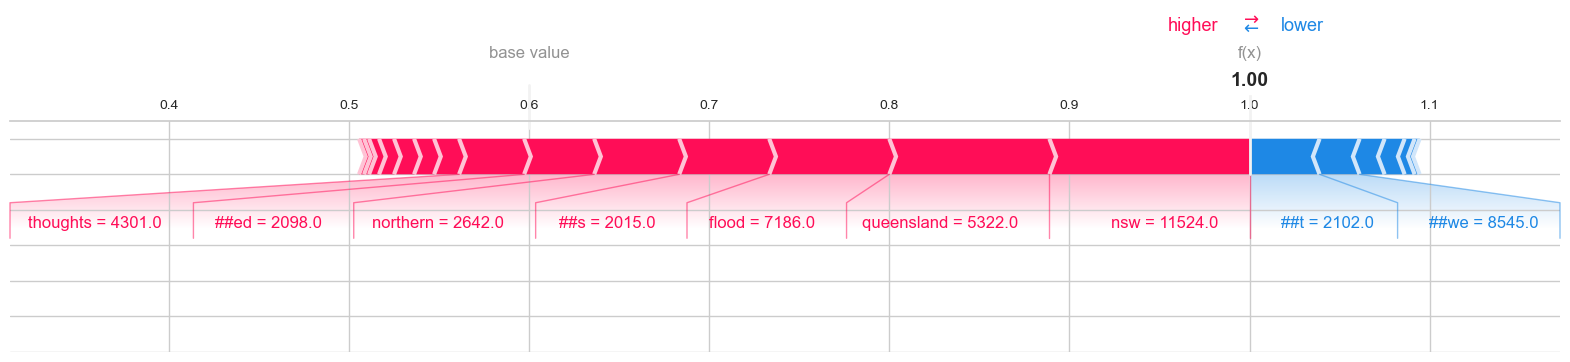

<class 'numpy.ndarray'> [[ 4658  4929  2147  6879 23961  6700  3334  3611 11651  2147  2644     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: cool wear work boots nt hips ##ter dad wears work stop ; Prediction: [1] ; True value: b'not_relevant'


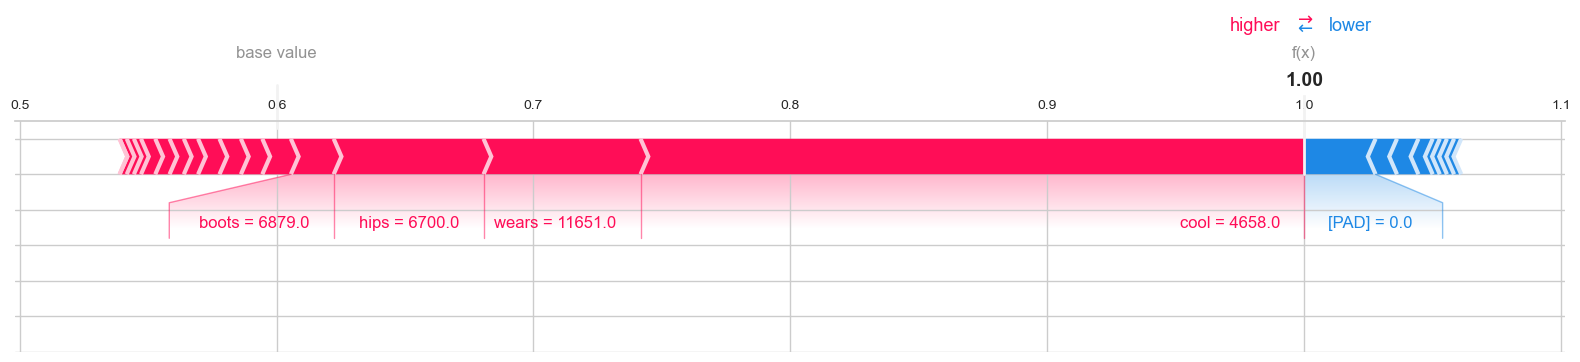

<class 'numpy.ndarray'> [[ 3647 12731  2480  2300  1044 18418  3298  2613  3647 12731  2480     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: safe cu ##z water h ##wy drive real safe cu ##z ; Prediction: [0] ; True value: b'not_relevant'


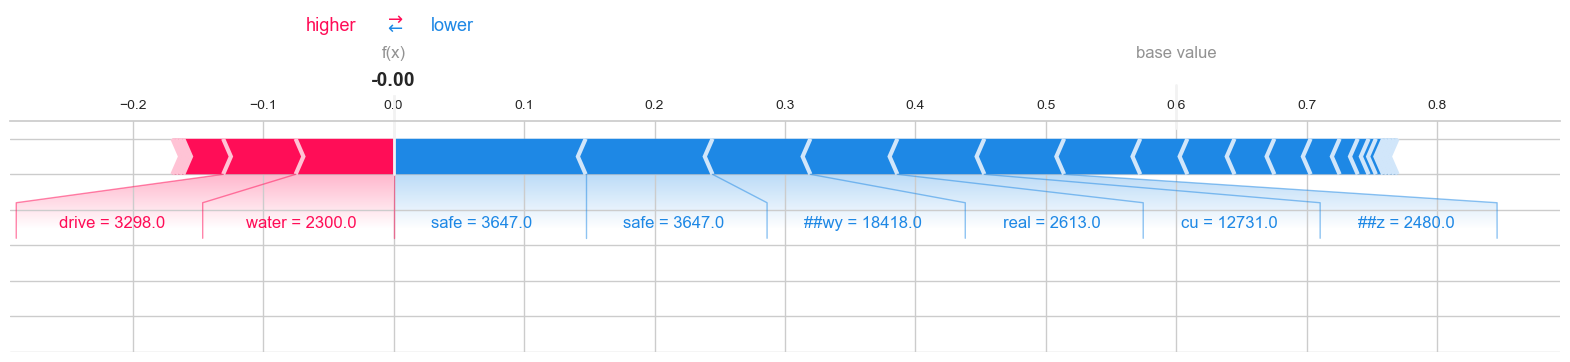

<class 'numpy.ndarray'> [[ 4748  2546  8456  7186  4550 21122  2850  4059  2533  4721  2510  2660
  17151  3207  2546 22975  2953  4160  2683  2549 25148  2080     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: ad ##f assists flood clean bun ##da ##berg department defence military australia aus ##de ##f tc ##or ##q ##9 ##4 ##lux ##o ; Prediction: [1] ; True value: b'relevant'


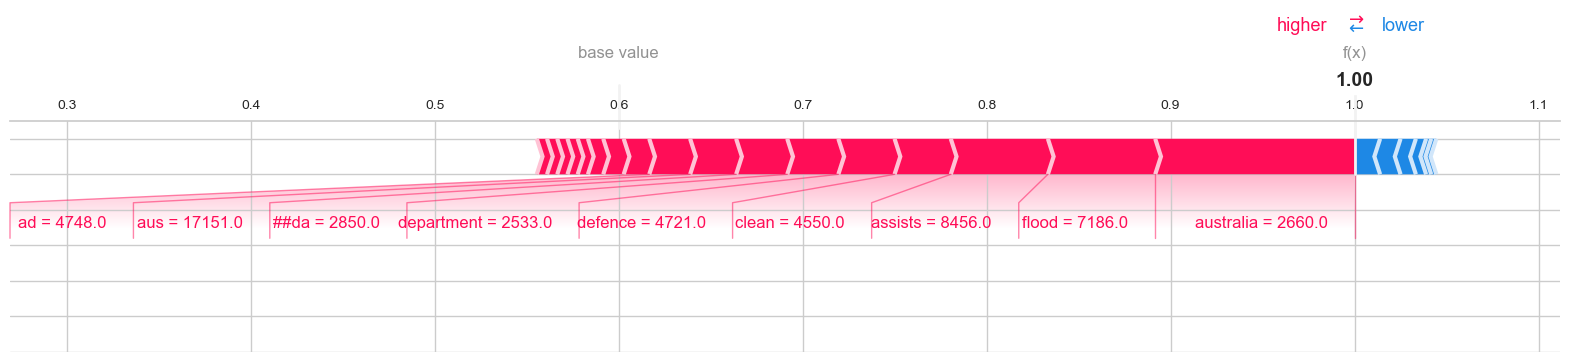

<class 'numpy.ndarray'> [[ 3707  2016  5480 29431  5963  2613 29431  5963  4485  2548  6824  3468
   1055 29431  4059     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: iron she ##ik ry ##back real ry ##back shit royal ##rum ##ble s ry ##berg ; Prediction: [0] ; True value: b'not_relevant'


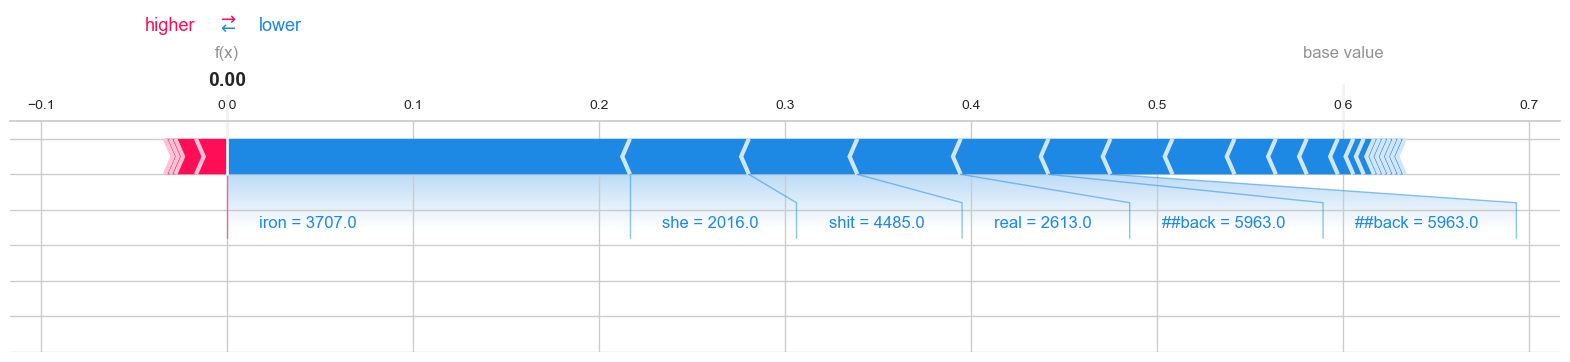

<class 'numpy.ndarray'> [[23961  5293 24260  3436  1015  2260 10733  2853  2651  2417  2892  5322
   7186  5574  1998 22975  9541  2080  2575  6137  6593  2487     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: nt forget dona ##ting 1 12 pizza sold today red cross queensland flood appeal and tc ##oo ##o ##6 ##ii ##ct ##1 ; Prediction: [1] ; True value: b'relevant'


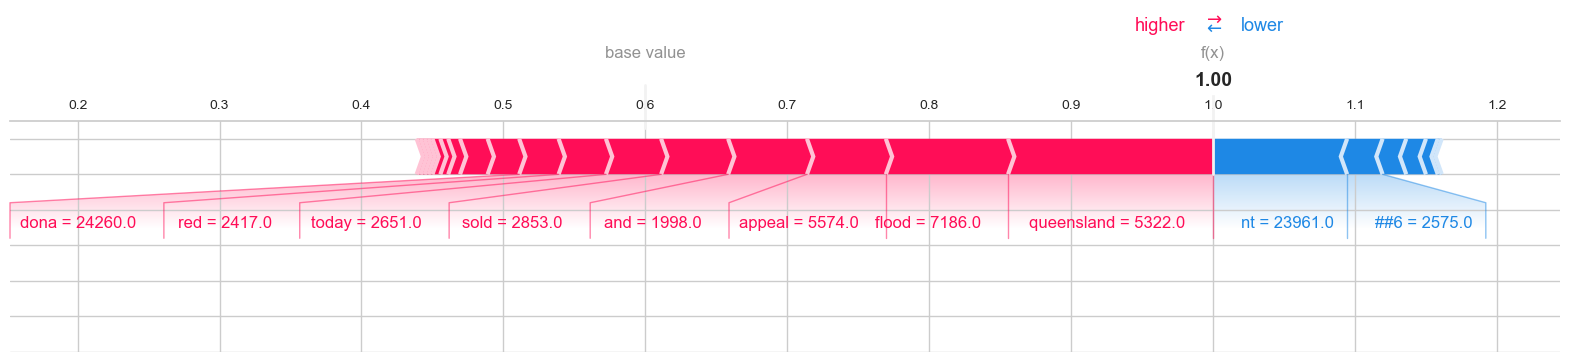

<class 'numpy.ndarray'> [[18164  3027  4542  3062  5322  2660  7483  2350  7186  2086     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: 212 ft rain fell queensland australia yesterday major flood years ; Prediction: [1] ; True value: b'relevant'


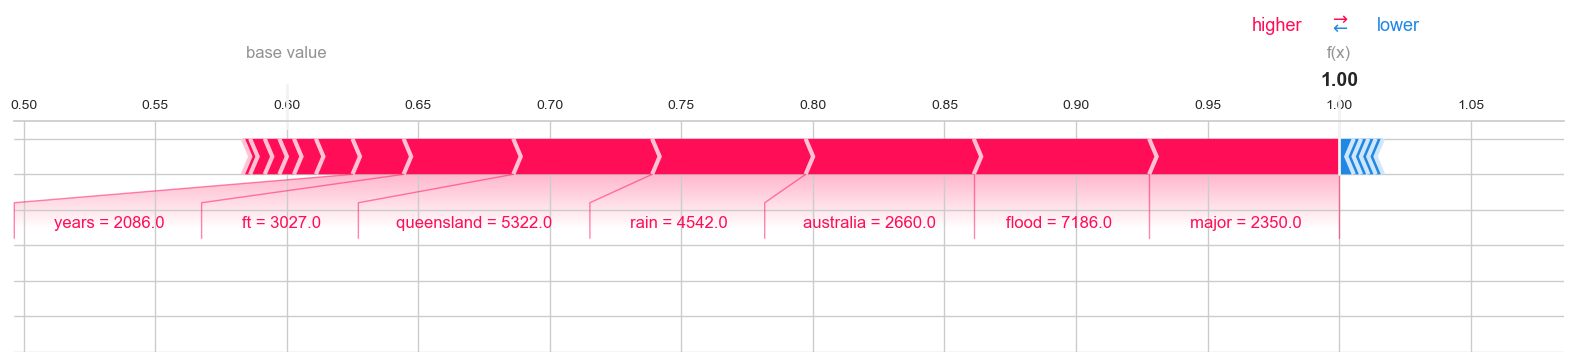

<class 'numpy.ndarray'> [[ 5322 17151 11741 14426 11564  2015  7186 22975  2080  2475 26132  2629
   4048  2290     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: queensland aus ##sie jakarta underwater ##s flood tc ##o ##2 ##vez ##5 ##hi ##g ; Prediction: [1] ; True value: b'relevant'


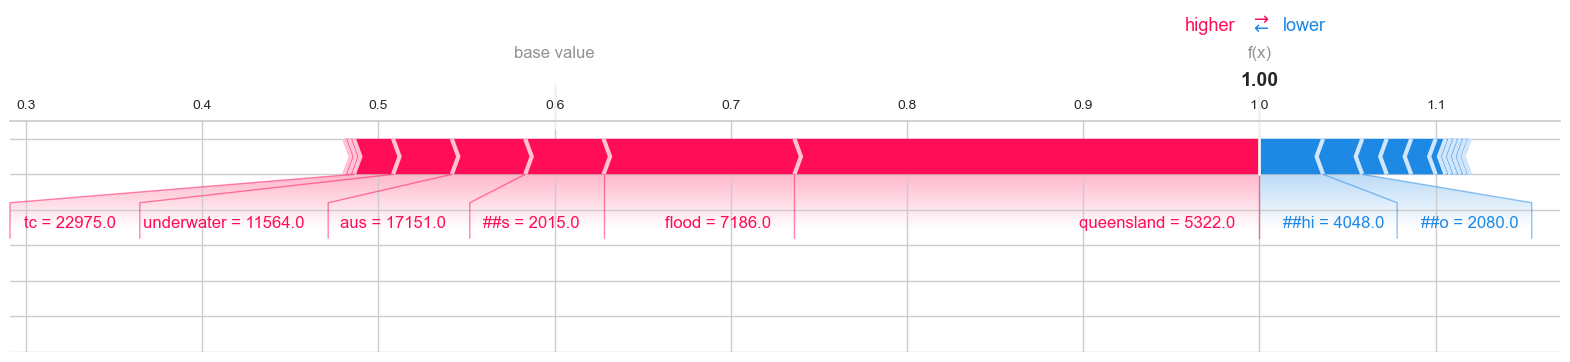

<class 'numpy.ndarray'> [[23961 17688  3057  3492     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: nt spice girls pretty ; Prediction: [0] ; True value: b'not_relevant'


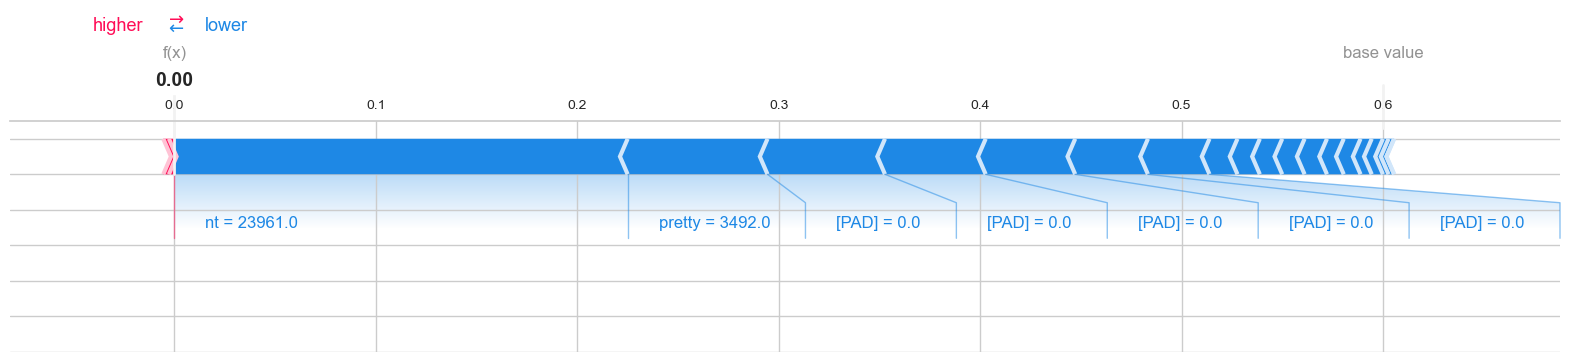

<class 'numpy.ndarray'> [[ 7760  7186  2300  9466  2660 22975  2080 23632 13102  2232  3489  2232
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: photos flood water rises australia tc ##o ##41 ##sp ##h ##ke ##h ; Prediction: [1] ; True value: b'relevant'


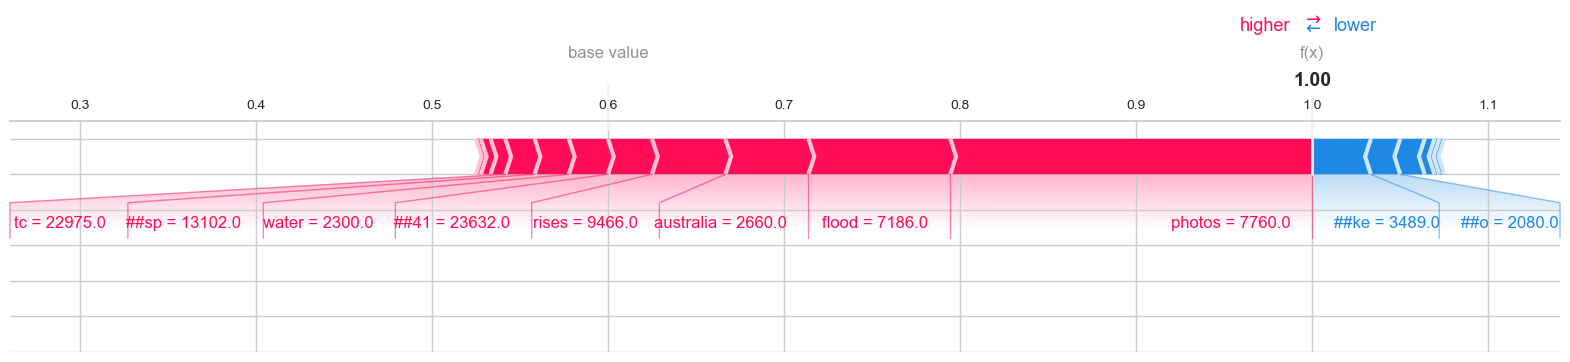

<class 'numpy.ndarray'> [[ 5322  9294  7186  3465  2148  3575 17180  2015  2314 11373 22975  4492
  28154 26337  2595  2497  4160     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: queensland counts flood cost south wales brace ##s river peaks tc ##ov ##59 ##fb ##x ##b ##q ; Prediction: [1] ; True value: b'relevant'


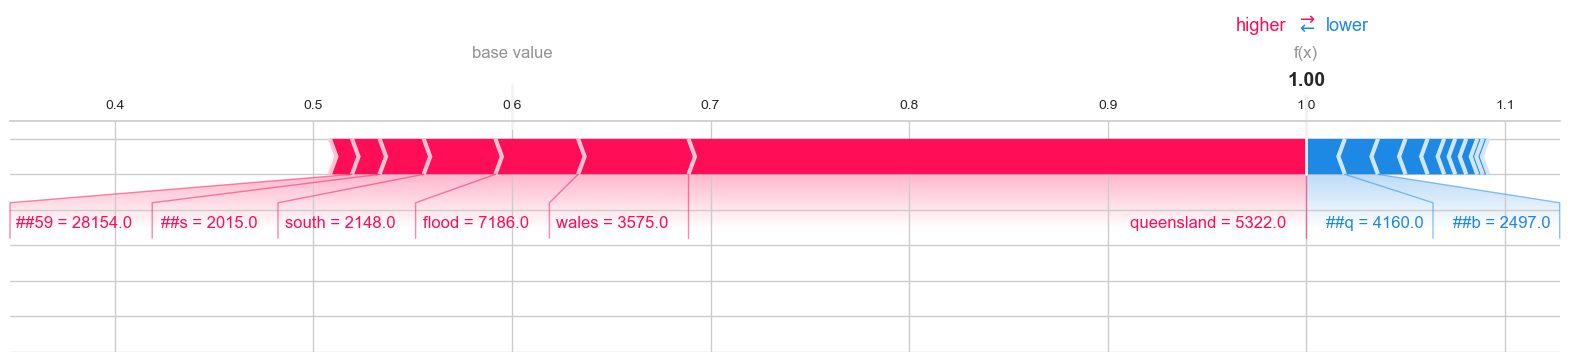

<class 'numpy.ndarray'> [[3456 6638 3334 5292 3270 3270 3270 9805 3600    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: legs fat ##ter ha ##ha ##ha ##ha yu ##ck ; Prediction: [0] ; True value: b'not_relevant'


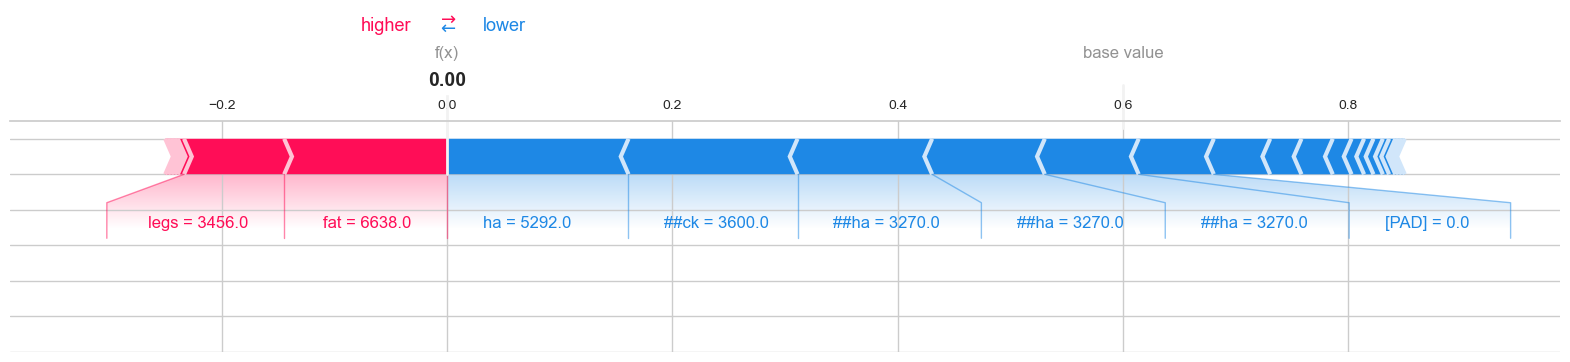

<class 'numpy.ndarray'> [[ 1053  4588 16171  5322  6813  5661  8556  7186  5375  7047 22975  5668
  20464  2226 19841  2546  2502  8545  2102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: q ##tic encourages queensland tourism businesses investigate flood assistance options tc ##ors ##cl ##u ##70 ##f big ##we ##t ; Prediction: [1] ; True value: b'relevant'


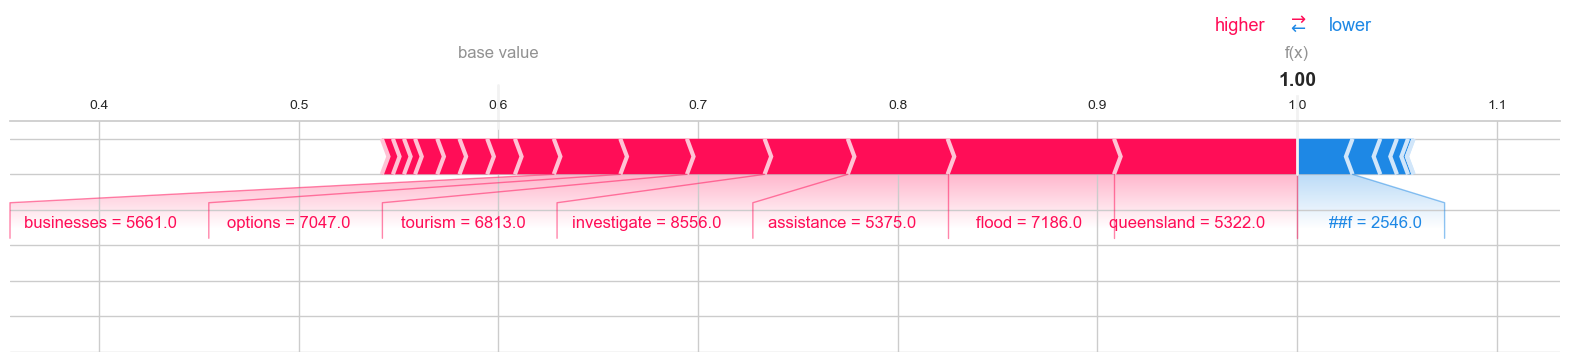

<class 'numpy.ndarray'> [[ 1032  1060  2278  2475  1032  1060  6305  4226  6132  3122  9294  7186
   3465  2148  3575 17180  2015  2314 11373 22975  2080  2629  2278  2595
   2475 22287 19279     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: \ x ##c ##2 \ x ##ac ##que ##ens ##land counts flood cost south wales brace ##s river peaks tc ##o ##5 ##c ##x ##2 ##km ##bt ; Prediction: [1] ; True value: b'relevant'


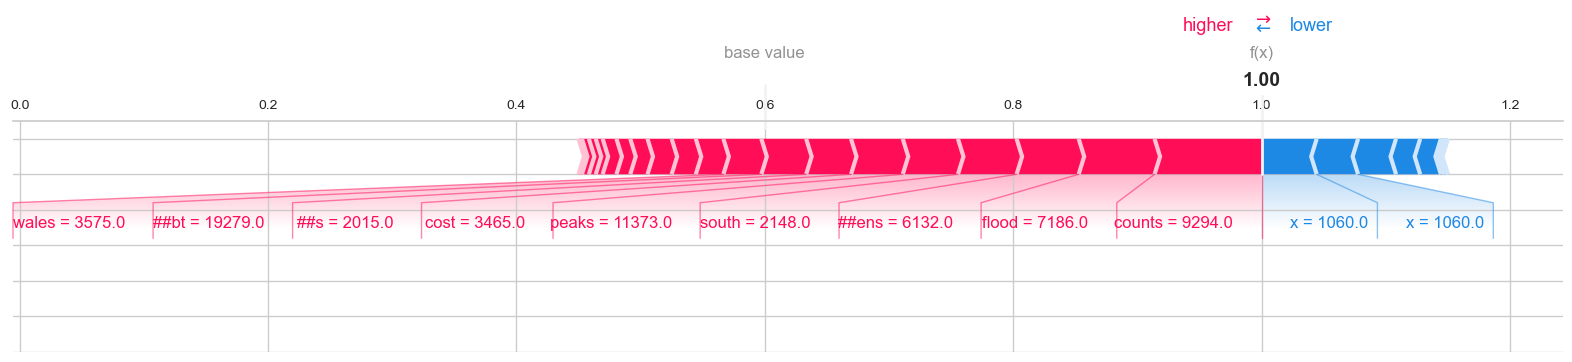

<class 'numpy.ndarray'> [[ 2128 26560  7741 23713  3666  5088 23961  3364 15509 20103     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: re ##hear ##sing amp watching nfl nt actor ##life musicals ; Prediction: [0] ; True value: b'not_relevant'


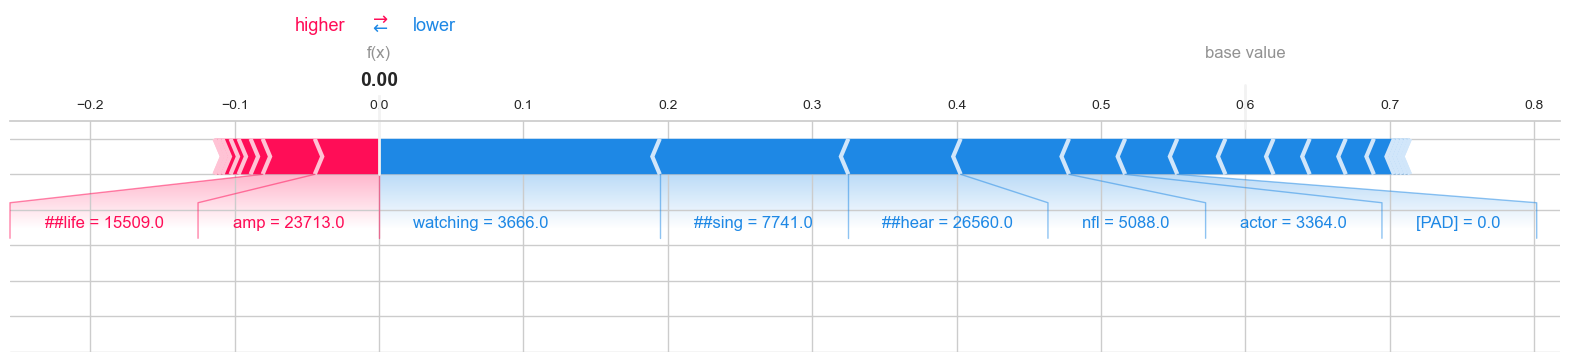

<class 'numpy.ndarray'> [[ 6300  2050  1055  2652  2161 23961  2191  2447  3246  7883  9252  1055
   2433     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: ye ##a s playing season nt make player hope carries deadly s form ; Prediction: [1] ; True value: b'not_relevant'


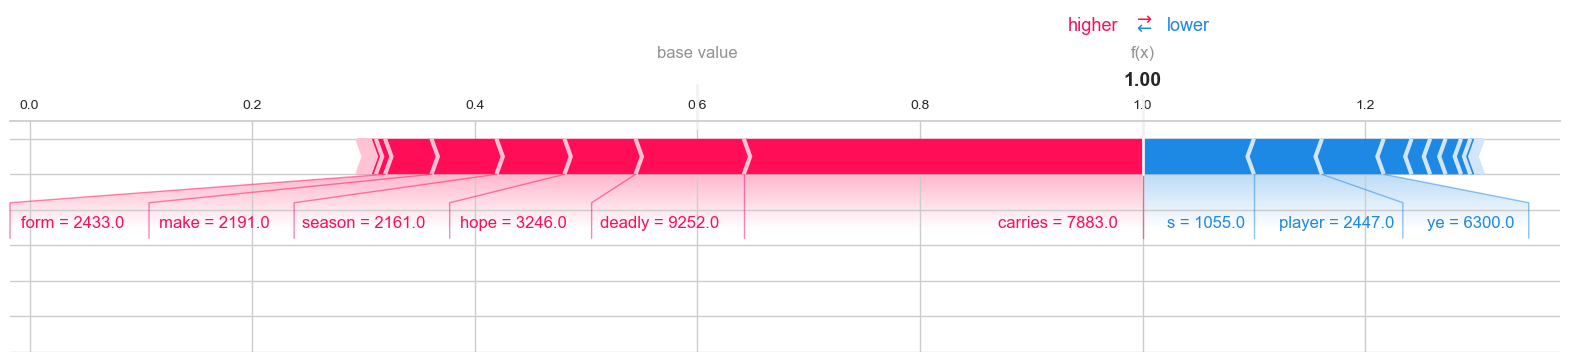

<class 'numpy.ndarray'> [[10201 24367  2482  7491  7813  9103  6610  7813  9103  6610  7813  9103
   6610  5299  6309  2482     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: laying bonnet car screaming beetle ##ju ##ice beetle ##ju ##ice beetle ##ju ##ice locked keys car ; Prediction: [0] ; True value: b'not_relevant'


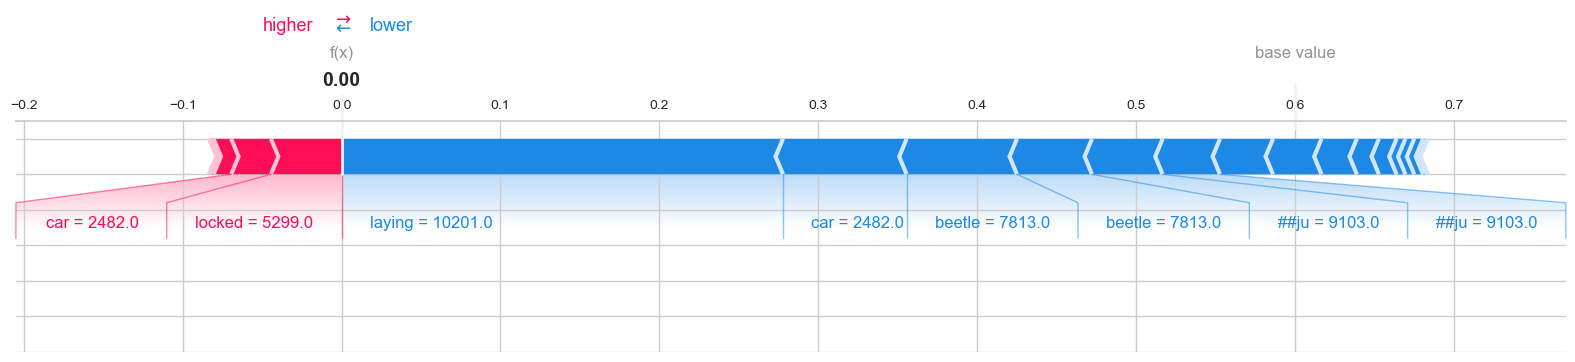

<class 'numpy.ndarray'> [[ 9252  7186  5380  4125  2789  2660 22975 19224  2594  7011  2361  4160
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: deadly flood waters rise eastern australia tc ##oud ##ic ##fa ##p ##q ; Prediction: [1] ; True value: b'relevant'


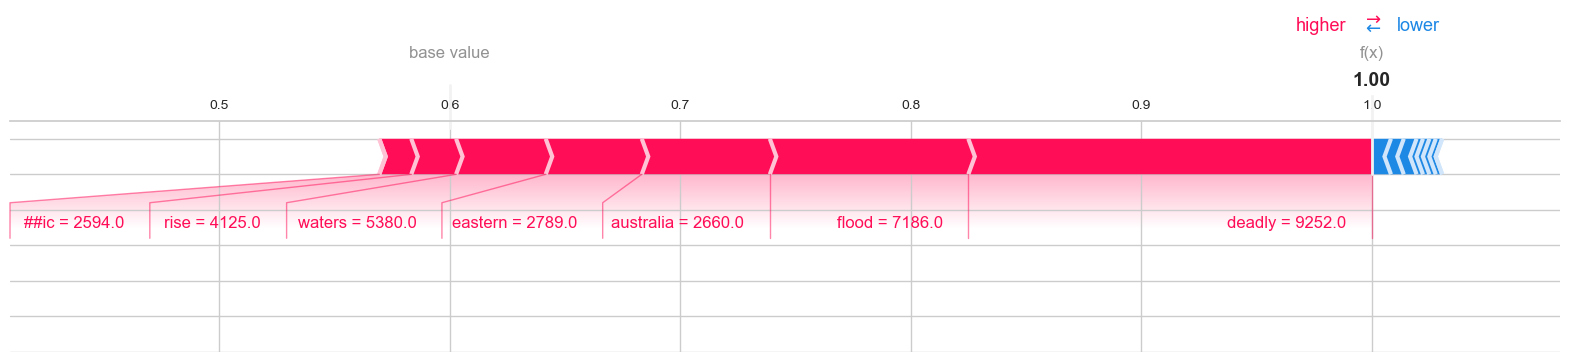

In [2]:
for i in range(len(X_test_padded)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(X_test_padded[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([X_test_padded[i]])), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [27]:
permutation_explainer = None
permutation_values = None

In [28]:
import numpy as np
import torch
from nltk.tokenize import TweetTokenizer
import logging

logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S")
logging.getLogger().setLevel(logging.INFO)


class SHAPexplainer:
    def __init__(self, model, tokenizer, words_dict, words_dict_reverse):
        self.model = model
        self.tokenizer = tokenizer
        self.device = "cpu"
        self.tweet_tokenizer = TweetTokenizer()
        self.words_dict = words_dict
        self.words_dict_reverse = words_dict_reverse

    def predict(self, indexed_words):
        # self.model.to(self.device)

        sentences = [
            [self.words_dict[xx] if xx != 0 else "" for xx in x] for x in indexed_words
        ]
        indexed_tokens, _, _ = self.tknz_to_idx(sentences)

        # ref = self.tweet_tokenizer.tokenize(data[0])
        # data_temp = [ref]
        # for x in data[1:]:
        #     ref_temp = ref.copy()
        #     new = ["" for _ in range(len(ref))]
        #     x = self.tweet_tokenizer.tokenize(x)
        #     for w in x:
        #         id = ref_temp.index(w)
        #         new[id] = w
        #         ref_temp[id] = ""
        #     data_temp.append(new)
        #
        # data_temp = [["[PAD]" if xx == "" else xx for xx in x] for x in data_temp]
        # data_temp = [" ".join(x) for x in data_temp]
        #
        # tokenized_nopad = [self.tokenizer.tokenize(text) for text in data_temp]
        # MAX_SEQ_LEN = max(len(x) for x in tokenized_nopad)
        # tokenized_text = [["[PAD]", ] * MAX_SEQ_LEN for _ in range(len(data))]
        # for i in range(len(data)):
        #     tokenized_text[i][0:len(tokenized_nopad[i])] = tokenized_nopad[i][0:MAX_SEQ_LEN]
        # indexed_tokens = [self.tokenizer.convert_tokens_to_ids(tt) for tt in tokenized_text]

        tokens_tensor = torch.tensor(indexed_tokens)
        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            # logits = outputs[0]
            predictions = np.array(outputs)
        final = [self.softmax(x) for x in predictions]
        return np.array(final)

    def softmax(self, it):
        exps = np.exp(np.array(it))
        return exps / np.sum(exps)

    def split_string(self, string):
        data_raw = self.tweet_tokenizer.tokenize(string)
        data_raw = [x for x in data_raw if x not in ".,:;'"]
        return data_raw

    def tknz_to_idx(self, train_data, MAX_SEQ_LEN=None):
        tokenized_nopad = [
            self.tokenizer.tokenize(" ".join(text)) for text in train_data
        ]
        if not MAX_SEQ_LEN:
            MAX_SEQ_LEN = min(max(len(x) for x in train_data), 512)
        tokenized_text = [
            [
                "[PAD]",
            ]
            * MAX_SEQ_LEN
            for _ in range(len(tokenized_nopad))
        ]
        for i in range(len(tokenized_nopad)):
            tokenized_text[i][0 : len(tokenized_nopad[i])] = tokenized_nopad[i][
                0:MAX_SEQ_LEN
            ]
        indexed_tokens = np.array(
            [
                np.array(self.tokenizer.convert_tokens_to_ids(tt))
                for tt in tokenized_text
            ]
        )
        return indexed_tokens, tokenized_text, MAX_SEQ_LEN

    def dt_to_idx(self, data, max_seq_len=None):
        idx_dt = [[self.words_dict_reverse[xx] for xx in x] for x in data]
        if not max_seq_len:
            max_seq_len = min(max(len(x) for x in idx_dt), 512)
        for i, x in enumerate(idx_dt):
            if len(x) < max_seq_len:
                idx_dt[i] = x + [0] * (max_seq_len - len(x))
        return np.array(idx_dt), max_seq_len


In [29]:
bag_of_words = []

for s in X_test_padded:
  for w in s:
    bag_of_words.append(w)

bag_of_words = np.unique(np.array(bag_of_words))

In [52]:
def predict_model(text_ids):
  bert_output = model(torch.from_numpy(np.array(text_ids)))
  sequence_output = bert_output[0].detach().numpy()
  print(clf.predict(sequence_output.reshape(text_ids.shape[0], 64*768)))
  return clf.predict(sequence_output.reshape(text_ids.shape[0], 64*768))

In [53]:
words_dict = {0:None}
words_dict_reverse = {None:0}

for w in bag_of_words:
    token = tokenizer.convert_ids_to_tokens([w])[0]
    words_dict[w] = token
    words_dict_reverse[token] = w

predictor = SHAPexplainer(predict_model, tokenizer, words_dict, words_dict_reverse)

In [54]:
test_text = []
for i in range(len(X_test_padded)):
  test_text.append(tokenizer.convert_ids_to_tokens(X_test_padded[i]))

In [55]:
idx_test_data, max_seq_len = predictor.dt_to_idx(test_text)
print(test_text[0])
print(idx_test_data)
print(max_seq_len)

['baby', '##y', '##y', 'game', 'co', '##s', 'n', '##xt', 'the', '##week', '##nd', '##ly', '##ric', '##s', 'bed', '##time', '##music', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[[ 3336  2100  2100 ...     0     0     0]
 [ 5322  1055  7186 ...     0     0     0]
 [23961  3233 18255 ...     0     0     0]
 ...
 [ 4699 11719     0 ...     0     0     0]
 [ 2739 14855 23940 ...     0     0     0]
 [ 2502 14804 10216 ...     0     0     0]]
64


In [4]:
idx_test_data.shape

(100, 64)

In [5]:
explainer = shap.KernelExplainer(model=predictor.predict, data=idx_test_data, link="identity", algorithm="linear")

#texts_ = [predictor.split_string(x) for x in test_text]
idx_texts, _ = predictor.dt_to_idx(test_text, max_seq_len=max_seq_len)

[0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0
 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0]


In [6]:
to_use = idx_texts[:5]
shap_values = explainer.shap_values(X=to_use, nsamples=64, l1_reg="aic")

  0%|          | 0/5 [00:00<?, ?it/s]

[0]
[0 1 0 ... 0 0 0]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 20%|██        | 1/5 [13:27<53:51, 807.99s/it]

[1]
[1 1 1 ... 1 1 1]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|████      | 2/5 [24:11<35:32, 710.95s/it]

[0]
[0 1 0 ... 0 0 0]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 60%|██████    | 3/5 [34:40<22:27, 673.94s/it]

[0]
[0 0 0 ... 0 0 0]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|████████  | 4/5 [45:15<10:58, 658.26s/it]

[0]
[0 1 0 ... 0 0 0]


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|██████████| 5/5 [58:51<00:00, 706.33s/it]


In [7]:
print(shap_values)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [59]:
len_ = len(test_text[0])
d = {i: sum(x > 0 for x in shap_values[i][0:len_]) for i in range(len(shap_values))}
m = max(d, key=d.get)
print(" ".join(test_text[-1:][0]))
shap.force_plot(explainer.expected_value, shap_values[m][0:len_], test_text[0])

big lad pump lead gear ja ##bber [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [1]:
import dill
filename = 'globalsave1.pkl'
# dill.dump_session(filename)

# and to load the session again:
dill.load_session(filename)

In [31]:
permutation_values

.values =
array([[-2.47222222e-01, -2.77777778e-03,  8.33333333e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.38888889e-01,  8.33333333e-03, -6.94444444e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.61111111e-02, -1.38888889e-02,  6.66666667e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.55555556e-02, -8.33333333e-03, -1.00000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.77777778e-01, -3.08395285e-18, -7.77777778e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.75000000e-01,  8.61111111e-02,  3.88888889e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

.base_values =
array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6])

.data =
array([[ 2095,  2222,  4469, ...,     0,     0,     0],
       [ 2843,  6082,  2128, ...,    

In [5]:
print(model(torch.from_numpy(np.array([X_test_padded[0]])).to(torch.int64)))
print(model(torch.from_numpy(np.array(X_test_padded[:5])).to(torch.int64)))


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1081,  0.1456,  0.0047,  ..., -0.8579,  0.6848,  0.1751],
         [-0.0939,  0.1939,  0.4574,  ..., -1.1593,  0.3729,  0.5345],
         [-0.2916,  0.0176,  0.0638,  ..., -1.0403,  0.1553,  0.4304],
         ...,
         [ 0.0411,  0.0400, -0.0340,  ..., -0.8876,  0.7862,  0.0988],
         [ 0.0376,  0.0371, -0.0380,  ..., -0.8718,  0.8106,  0.1178],
         [ 0.0422,  0.0555, -0.0485,  ..., -0.8560,  0.8056,  0.1082]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.2200, -0.1757,  0.0195,  0.2688,  0.8024, -0.2478, -0.3083, -0.0228,
         -0.0065,  0.2887,  0.2225,  0.8894,  0.8536, -0.6990,  0.8399,  0.2609,
         -0.1592,  0.2252,  0.2722,  0.8007,  0.7612,  0.9963,  0.2210,  0.1533,
          0.2538,  0.8233, -0.6452,  0.9051,  0.8183,  0.6572, -0.0323,  0.1897,
         -0.9918, -0.1398, -0.7315, -0.5609,  0.1319, -0.3303,  0.0599,  0.2193,
         -0.8756,  0.1223,  0.78